custom MAPE ?
svm taking forever

# Setup

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

## Defining functions

In [2]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [3]:
def customized_MAPE(true_values, predicted_values):
    true_values, predicted_values = np.array(true_values), np.array(predicted_values)
    Mape = np.mean(np.abs((true_values - predicted_values + 5) / (true_values + 5)))
    return Mape

In [4]:
def load_data(train_size, test_size):
    urls = ['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet',
              'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet',
              'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet',
              'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-04.parquet']

    for index in range(len(urls)):
        response = requests.get(urls[index])
        name = 'm' + str(index + 1) + '.parquet'

        with open(name, 'wb') as f:
            f.write(response.content)


    train_data = []
    test_data = []
    #train part
    for i in range(train_size):
        name = 'm' + str(i + 1) + '.parquet'
        data = pd.read_parquet(name)
        train_data.append(data)
    #test part
    for j in range(test_size):
        name = 'm' + str(j + train_size + 1) + '.parquet'
        data = pd.read_parquet(name)
        test_data.append(data)
    return train_data, test_data

In [5]:
def date_format_modifier(datas):# Year/Month/Day
    modified_datas = []
    for data in datas:
        data['month'] = pd.DataFrame([int(date.strftime("%m")) for date in data['tpep_pickup_datetime']])
        data['tpep_pickup_datetime'] = pd.DataFrame([int(date.strftime("%d")) for date in data['tpep_pickup_datetime']])
        data = data.dropna()
        modified_datas.append(data)

    return modified_datas

In [6]:
def location_format_modifier(data):# run after merging datasets and modifing date

    data['prev_demand'] = data.groupby(['PULocationID', 'month'])['Demand'].shift(1)

    # replace "loc_id" values with previous day's "Demand" values
    data['PULocationID'] = data.apply(lambda x: x['prev_demand'] if pd.notna(x['prev_demand']) else None, axis=1)

    # drop the temporary "prev_demand" column
    data.drop(columns=['prev_demand'], inplace=True)
    data = data.dropna()

    return data

In [7]:
def grouping_by(data, group_list):
    data_grouped = data.groupby(group_list, as_index = False)['extra'].count()
    data_grouped = data_grouped.rename(columns={'extra' : 'Demand'})

    return data_grouped

In [8]:
def clearing_data_noise(datas, months):
    clean_datas = []
    for index in range(len(datas)):
        month = months[index]
        data = datas[index]

        clean_data = data[[int(date.strftime("%m")) == month for date in data['tpep_pickup_datetime']]]
        clean_data = clean_data.dropna()
        clean_datas.append(clean_data)
    return clean_datas

In [9]:
def lower_upper_bound_predict(model, model_numbers, sample_size, train_data, test_data):

    feature_num = len(group_list)
    num_samples = train_data.shape[0]
    indices = np.arange(num_samples)  # Create an array of indices

    bagging_test_predictions = []
    bagging_train_predictions = []
    for i in range(model_numbers):

      resampled_indices  = np.random.choice(indices, size = int(sample_size * num_samples), replace = True) #cant resample from n-d array so we are sampling indices
      resampled_data = train_data[resampled_indices]

      model.fit(resampled_data[:, :feature_num], resampled_data[:, feature_num:].reshape(-1,))

      test_predictions = model.predict(test_data[:, :feature_num])
      train_predictions = model.predict(train_data[:, :feature_num])

      bagging_test_predictions.append(test_predictions)
      bagging_train_predictions.append(train_predictions)

    bagging_test_predictions = np.array(bagging_test_predictions)
    bagging_train_predictions = np.array(bagging_train_predictions)

    test_lower_bound = np.percentile(bagging_test_predictions, 5, axis=0)
    test_upper_bound = np.percentile(bagging_test_predictions, 95, axis=0)

    train_lower_bound = np.percentile(bagging_train_predictions, 5, axis=0)
    train_upper_bound = np.percentile(bagging_train_predictions, 95, axis=0)

    return (train_lower_bound, train_upper_bound), (test_lower_bound, test_upper_bound)

In [10]:
def bound_visualizer(train_data, test_data, train_bounds, test_bounds, end_day):
    plot_length = len(train_data['Demand'][1: end_day])
    plt.title('Train')
    plt.plot(train_data['Demand'][1: end_day])
    plt.plot(np.linspace(1, end_day, plot_length), train_bounds[0][:plot_length].reshape(-1,))
    plt.plot(np.linspace(1, end_day, plot_length), train_bounds[1][:plot_length].reshape(-1,))
    plt.show()

    plot_length = len(test_data['Demand'][1: end_day])
    plt.title('Test')
    plt.plot(test_data['Demand'][1: end_day])
    plt.plot(np.linspace(1, end_day, plot_length), test_bounds[0][:plot_length].reshape(-1,))
    plt.plot(np.linspace(1, end_day, plot_length), test_bounds[1][:plot_length].reshape(-1,))
    plt.show()

In [11]:
def grid_search(model, parameters, train_data, cv = None):
    gs = GridSearchCV(model, parameters, cv=cv)
    feature_num = len(group_list)
    gs.fit(train_data[:, :feature_num], train_data[:, feature_num:].reshape(-1,))
    return gs.best_params_

In [12]:
def point_predict(model, train_data, test_data):

    feature_num = len(group_list)
    model.fit(train_data[:, :feature_num], train_data[:, feature_num:].reshape(-1,))


    yhat_train = model.predict(train_data[:, :feature_num])
    yhat_test = model.predict(test_data[:, :feature_num])

    return yhat_train, yhat_test

In [13]:
def sum_of_demands_visualizer(data, title):
    grouped_data = data.groupby('tpep_pickup_datetime')['Demand'].sum()
    plt.title(title)
    plt.plot(grouped_data)
    plt.show()

In [14]:
def point_predict_visualizer(train_data, test_data, yhat_train, yhat_test):

    predicted_train_df = train_data.copy(deep = True)
    predicted_test_df = test_data.copy(deep = True)
    predicted_train_df['Predicted'] = yhat_train
    predicted_test_df['Predicted'] = yhat_test


    train_data = train_data.groupby('tpep_pickup_datetime')['Demand'].sum()
    test_data = test_data.groupby('tpep_pickup_datetime')['Demand'].sum()

    predicted_train_df = predicted_train_df.groupby('tpep_pickup_datetime')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('tpep_pickup_datetime')['Predicted'].sum()



    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

In [15]:
def concating_data(datas):
    data_combined = pd.concat(datas, axis=0)
    return data_combined

In [16]:
def evaluation(model_name, yhat_train, yhat_test):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_loc_modified['Demand'], yhat_train)
    evaluate(mean_squared_error, 'MSE', train_loc_modified['Demand'], yhat_train)
    evaluate(customized_MAPE, 'MAPE', train_loc_modified['Demand'], yhat_train)

    print(f'{model_name} test scores:')


    evaluate(mean_absolute_error, 'MAE', test_loc_modified['Demand'], yhat_test)
    evaluate(mean_squared_error, 'MSE', test_loc_modified['Demand'], yhat_test)
    evaluate(customized_MAPE, 'MAPE', test_loc_modified['Demand'], yhat_test)


In [17]:
def sort_metrics_values(metrics_values):
    metrics_train_values  = metrics_values['train']
    metrics_test_values = metrics_values['test']

    sorted_train_metrics = sorted(metrics_train_values, key=lambda x: x[1]['RMSE'], reverse = True)
    sorted_test_metrics = sorted(metrics_test_values, key=lambda x: x[1]['RMSE'], reverse = True)

    sorted_metrics_values = {'train': sorted_train_metrics, 'test': sorted_test_metrics}
    return sorted_metrics_values

In [18]:
def evaluate_each_location(fitted_model, train_data, test_data):
    metrics_values = {'train' : [], 'test': []}
    feature_num = len(group_list)
    for loc_id in range(loc_id_num):
        sample_train_data = train_data[train_data['PULocationID'] == loc_id].to_numpy()
        sample_test_data = test_data[test_data['PULocationID'] == loc_id].to_numpy()
        if len(sample_train_data) != 0:
            yhat_train_sample = fitted_model.predict(sample_train_data[:, :feature_num])
            metrics_values['train'].append([loc_id, {'RMSE' : np.sqrt(mean_squared_error(sample_train_data[:, feature_num:], yhat_train_sample)),
                                                      'MAE' : mean_absolute_error(sample_train_data[:, feature_num:], yhat_train_sample)}])
        if len(sample_test_data) != 0:
            yhat_test_sample = fitted_model.predict(sample_test_data[:, :feature_num])
            metrics_values['test'].append([loc_id, {'RMSE' : np.sqrt(mean_squared_error(sample_test_data[:, feature_num:], yhat_test_sample)),
                                                      'MAE' : mean_absolute_error(sample_test_data[:, feature_num:], yhat_test_sample)}])
    return sort_metrics_values(metrics_values)

In [55]:
def get_locations_mean_demand(locations_id, data):
    sum_demands = []
    for location_id in locations_id:
        sum_demands.append({location_id : data[data['PULocationID'] == location_id]['Demand'].mean()})
    return sum_demands

# Main

## initialization and loading dataset

In [20]:
group_list = ['tpep_pickup_datetime', 'month', 'PULocationID']
loc_id_num = 266
train_size = 3
test_size = 1

In [21]:
train_data, test_data = load_data(train_size, test_size)

## Preprocessing

In [22]:
train_data = clearing_data_noise(train_data, [1,2,3])
test_data = clearing_data_noise(test_data, [4])

In [23]:
train_date_modified = date_format_modifier(train_data)
test_date_modified = date_format_modifier(test_data)

In [24]:
train_data = concating_data(train_date_modified)
test_data = concating_data(test_date_modified)

In [25]:
train_grouped = grouping_by(train_data, group_list)
test_grouped = grouping_by(test_data, group_list)

In [26]:
train_loc_modified = location_format_modifier(train_grouped)
test_loc_modified = location_format_modifier(test_grouped)

## **Linear Regression**

#### Point based prediction

In [45]:
model = LinearRegression()
yhat_train, yhat_test = point_predict(model, train_loc_modified.to_numpy(), test_loc_modified.to_numpy())

##### Visualization

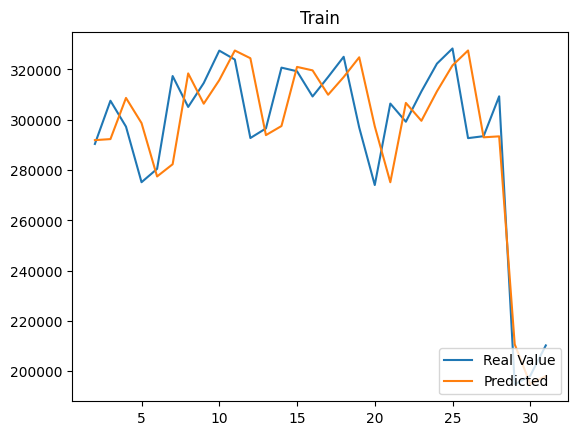

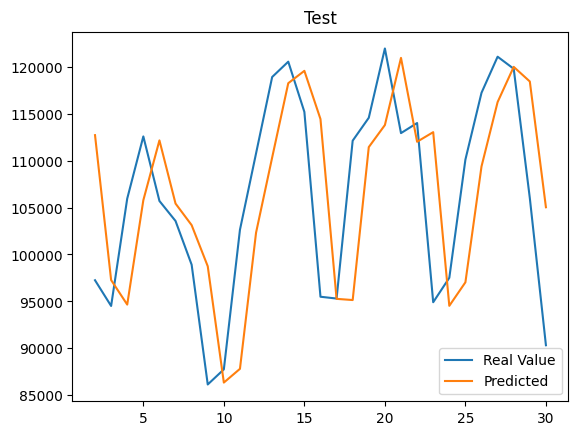

In [46]:
point_predict_visualizer(train_loc_modified, test_loc_modified, yhat_train, yhat_test)

##### Evaluation

In [47]:
evaluation('Linear Regression', yhat_train, yhat_test)# for whole data

Linear Regression train scores:
MAE : 84.28189388581556
MSE : 56133.612302419635
MAPE : 0.643705511412065
Linear Regression test scores:
MAE : 81.58006966982884
MSE : 51542.70606544089
MAPE : 0.43672422128125965


In [48]:
sorted_metrics_values = evaluate_each_location(model, train_loc_modified, test_loc_modified)# for each location

In [49]:
sorted_metrics_values['train'][:10]

[[234, {'RMSE': 148.4787468403562, 'MAE': 101.91794700282827}],
 [241, {'RMSE': 129.76934319060524, 'MAE': 127.21574653264595}],
 [226, {'RMSE': 120.68761369875935, 'MAE': 91.1508362800431}],
 [223, {'RMSE': 112.59158319607779, 'MAE': 84.72831076812336}],
 [206, {'RMSE': 112.39855727396863, 'MAE': 95.02106159992354}],
 [191, {'RMSE': 108.66094408896686, 'MAE': 65.75912761803592}],
 [229, {'RMSE': 108.50442282412148, 'MAE': 80.47219133888461}],
 [225, {'RMSE': 108.43207012980311, 'MAE': 82.71978765999378}],
 [207, {'RMSE': 108.27829411600146, 'MAE': 88.82957529879971}],
 [195, {'RMSE': 106.87743265816489, 'MAE': 82.36630060635174}]]

In [ ]:
train_loc_modified['Demand'].mean()

469.0255772082186

In [56]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['train'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, train_loc_modified)

[{234: 318.3333333333333},
 {241: 229.0},
 {226: 163.0},
 {223: 160.66666666666666},
 {206: 166.33333333333334},
 {191: 245.66666666666666},
 {229: 194.0},
 {225: 147.75},
 {207: 277.5},
 {195: 152.0}]

In [59]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['test'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, test_loc_modified)

[{244: 38.0},
 {222: 184.0},
 {151: 40.0},
 {177: 110.5},
 {165: 78.5},
 {149: 58.0},
 {210: 119.0},
 {254: 167.0},
 {111: 170.75},
 {251: 168.0}]

## **Random Forest Regressor**

#### Point based prediction

##### Grid search to find best hyper parameters

In [62]:
model = RandomForestRegressor()
best_params = grid_search(model, {'n_estimators' : [100, 200], 'max_depth' : [4, 7, 10]}, train_loc_modified.to_numpy(), cv = None)

In [63]:
model = RandomForestRegressor(**best_params)
yhat_train, yhat_test = point_predict(model, train_loc_modified.to_numpy(), test_loc_modified.to_numpy())

##### Visualization

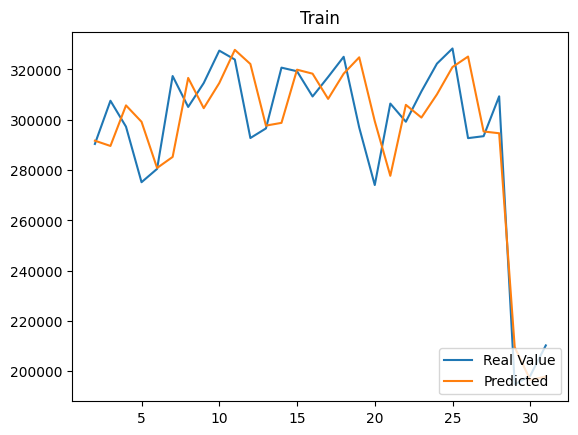

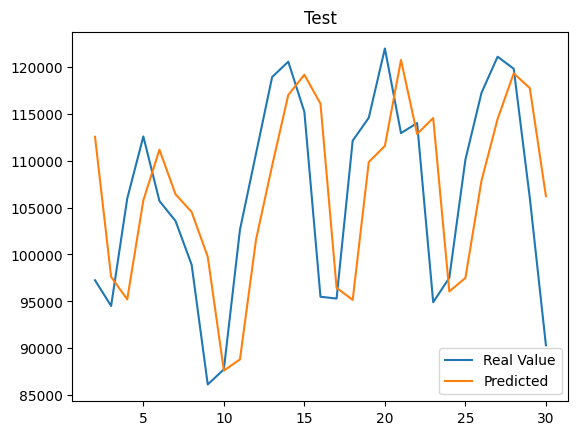

In [64]:
point_predict_visualizer(train_loc_modified, test_loc_modified, yhat_train, yhat_test)

##### Evaluation

In [65]:
evaluation('Random Forest Regressor', yhat_train, yhat_test)# for whole data

Random Forest Regressor train scores:
MAE : 77.02243683272047
MSE : 51723.740687898724
MAPE : 0.28348603732647065
Random Forest Regressor test scores:
MAE : 78.78660097099161
MSE : 51852.45377046578
MAPE : 0.28688659299623887


In [66]:
sorted_metrics_values = evaluate_each_location(model, train_loc_modified, test_loc_modified)# for each location

In [67]:
sorted_metrics_values['train'][:10]

[[234, {'RMSE': 157.16898373766725, 'MAE': 106.32206071988831}],
 [241, {'RMSE': 127.63018805623919, 'MAE': 119.01127261344503}],
 [207, {'RMSE': 112.4171884904394, 'MAE': 90.5}],
 [218, {'RMSE': 111.06865191396109, 'MAE': 65.46769557791124}],
 [226, {'RMSE': 110.77532919807521, 'MAE': 83.69897108875541}],
 [195, {'RMSE': 109.4831701774588, 'MAE': 84.50494794324462}],
 [206, {'RMSE': 109.45891724056925, 'MAE': 91.97884323567591}],
 [191, {'RMSE': 105.55780631800566, 'MAE': 60.828385390088705}],
 [259, {'RMSE': 104.01382117689961, 'MAE': 69.79230214316647}],
 [223, {'RMSE': 103.20509913525515, 'MAE': 79.36563775542207}]]

In [68]:
train_loc_modified['Demand'].mean()

469.0255772082186

In [69]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['train'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, train_loc_modified)

[{234: 318.3333333333333},
 {241: 229.0},
 {207: 277.5},
 {218: 271.8333333333333},
 {226: 163.0},
 {195: 152.0},
 {206: 166.33333333333334},
 {191: 245.66666666666666},
 {259: 293.75},
 {223: 160.66666666666666}]

In [70]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['test'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, test_loc_modified)

[{244: 38.0},
 {177: 110.5},
 {222: 184.0},
 {111: 170.75},
 {260: 331.0},
 {165: 78.5},
 {151: 40.0},
 {123: 168.0},
 {193: 115.0},
 {210: 119.0}]

## **SVM**

#### Point based prediction

##### Grid search to find best hyper parameters

In [ ]:
'''model = svm.SVR()
best_params = grid_search(model, {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],
                                  'kernel': ['rbf', 'poly', 'sigmoid']}, train_loc_modified.to_numpy(), cv = None)'''

In [44]:
best_params = {'C': 1, 'gamma': 0.1, 'kernel':'poly', 'degree' : 3}

In [ ]:
model = svm.SVR(**best_params)
yhat_train, yhat_test = point_predict(model, train_loc_modified.to_numpy(), test_loc_modified.to_numpy())

##### Visualization

In [ ]:
point_predict_visualizer(train_loc_modified, test_loc_modified, yhat_train, yhat_test)

##### Evaluation

In [ ]:
evaluation('SVM Regressor', yhat_train, yhat_test)# for whole data

In [ ]:
sorted_metrics_values = evaluate_each_location(model, train_loc_modified, test_loc_modified)# for each location

In [ ]:
sorted_metrics_values['train'][:10]

[[234, {'RMSE': 148.4787468403562, 'MAE': 101.91794700282827}],
 [241, {'RMSE': 129.76934319060524, 'MAE': 127.21574653264595}],
 [226, {'RMSE': 120.68761369875935, 'MAE': 91.1508362800431}],
 [223, {'RMSE': 112.59158319607779, 'MAE': 84.72831076812336}],
 [206, {'RMSE': 112.39855727396863, 'MAE': 95.02106159992354}],
 [191, {'RMSE': 108.66094408896686, 'MAE': 65.75912761803592}],
 [229, {'RMSE': 108.50442282412148, 'MAE': 80.47219133888461}],
 [225, {'RMSE': 108.43207012980311, 'MAE': 82.71978765999378}],
 [207, {'RMSE': 108.27829411600146, 'MAE': 88.82957529879971}],
 [195, {'RMSE': 106.87743265816489, 'MAE': 82.36630060635174}]]

In [ ]:
train_loc_modified['Demand'].mean()

469.0255772082186

In [ ]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['train'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, train_loc_modified)

[{234: 496},
 {241: 409},
 {226: 264},
 {223: 254},
 {206: 283},
 {191: 456},
 {229: 291},
 {225: 222},
 {207: 368},
 {195: 251}]

In [ ]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['test'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, test_loc_modified)

[{244: 38},
 {222: 296},
 {151: 40},
 {177: 193},
 {165: 122},
 {149: 58},
 {210: 119},
 {254: 167},
 {111: 289},
 {251: 168}]

## **KNN**

#### Point based prediction

##### Grid search to find best hyper parameters

In [71]:
model = KNeighborsRegressor()
best_params = grid_search(model, {'n_neighbors' : list(range(2,100))}, train_loc_modified.to_numpy(), cv = None)

In [72]:
model = KNeighborsRegressor(**best_params)
yhat_train, yhat_test = point_predict(model, train_loc_modified.to_numpy(), test_loc_modified.to_numpy())

##### Visualization

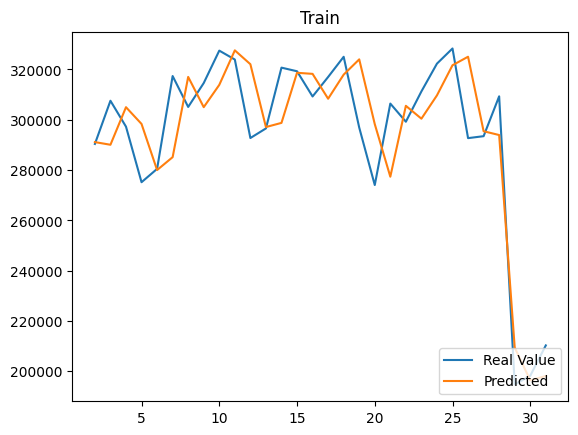

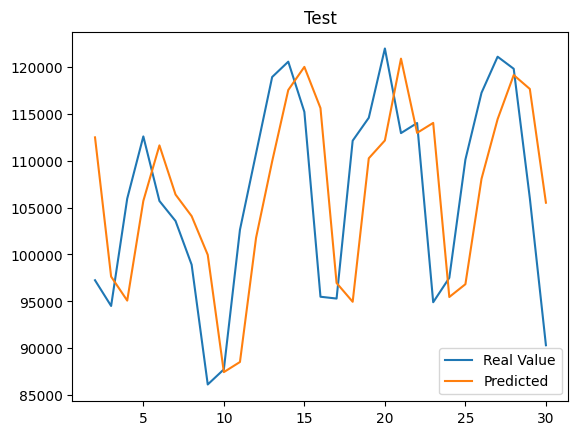

In [73]:
point_predict_visualizer(train_loc_modified, test_loc_modified, yhat_train, yhat_test)

##### Evaluation

In [74]:
evaluation('KNN Regressor', yhat_train, yhat_test)# for whole data

KNN Regressor train scores:
MAE : 75.42057995573279
MSE : 52012.13375077486
MAPE : 0.39623300789977006
KNN Regressor test scores:
MAE : 76.96779819257169
MSE : 51432.533826300205
MAPE : 0.38406162323843346


In [75]:
sorted_metrics_values = evaluate_each_location(model, train_loc_modified, test_loc_modified)# for each location

In [76]:
sorted_metrics_values['train'][:10]

[[234, {'RMSE': 165.12386156771896, 'MAE': 111.65217391304346}],
 [241, {'RMSE': 129.32689880641004, 'MAE': 121.5942028985507}],
 [207, {'RMSE': 117.79305248447629, 'MAE': 92.80434782608697}],
 [218, {'RMSE': 114.21976781414988, 'MAE': 68.55072463768117}],
 [191, {'RMSE': 111.49487580329769, 'MAE': 69.30434782608695}],
 [206, {'RMSE': 110.27703842953396, 'MAE': 91.92753623188406}],
 [226, {'RMSE': 108.80946891286516, 'MAE': 82.06763285024155}],
 [223, {'RMSE': 104.7206771360927, 'MAE': 78.52173913043478}],
 [229, {'RMSE': 101.2183671326037, 'MAE': 79.96376811594203}],
 [195, {'RMSE': 100.59836418086735, 'MAE': 76.14975845410628}]]

In [77]:
train_loc_modified['Demand'].mean()

469.0255772082186

In [78]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['train'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, train_loc_modified)

[{234: 318.3333333333333},
 {241: 229.0},
 {207: 277.5},
 {218: 271.8333333333333},
 {191: 245.66666666666666},
 {206: 166.33333333333334},
 {226: 163.0},
 {223: 160.66666666666666},
 {229: 194.0},
 {195: 152.0}]

In [79]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['test'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, test_loc_modified)

[{244: 38.0},
 {222: 184.0},
 {177: 110.5},
 {151: 40.0},
 {111: 170.75},
 {210: 119.0},
 {165: 78.5},
 {254: 167.0},
 {149: 58.0},
 {193: 115.0}]